<a href="https://colab.research.google.com/github/zulmarina1687/MCC-VA/blob/main/Lab1_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [3]:
file_name = "tigre"
path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/"

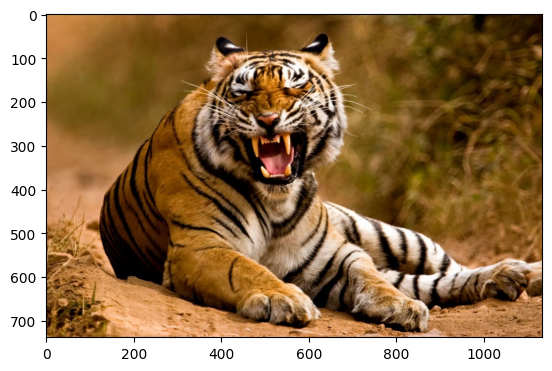

In [4]:
img = plt.imread(path+file_name+'.jpg')
plt.imshow(img)
plt.show()

In [5]:
import os
import subprocess

In [6]:
!apt install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [7]:
!pip install nvcc4jupyter

In [8]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpsor6vyw2".


In [9]:
COMPILER_ARGS = subprocess.check_output(["pkg-config", "--cflags", "--libs", "opencv4"]).decode().strip()
print(COMPILER_ARGS)

-I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [10]:
%%cuda --compiler-args "$COMPILER_ARGS"
#include <bits/stdc++.h>
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;

string file_name = "tigre";
string path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/";

std::string output_file;

__global__ void convH(float *d_imgFR, float *d_kernel, float *d_salida, int w, int h, int ch, int kernelDim){

    int bidx = blockIdx.x;
    int bidy = blockIdx.y;
    int bidz = blockIdx.z;

    int tidx = threadIdx.x;
    int tidy = threadIdx.y;

    int fil = bidx*w*ch;
    int col = bidy*ch;

    int kernelFil = ( bidx + (bidz-(kernelDim/2)) )*w*ch;
    int kernelCol = ( bidy + (tidx-(kernelDim/2)) )*ch;

    if (kernelFil>=0 && kernelFil<h*w*ch && kernelCol>=0 && kernelCol<w*ch){

      float suma = d_imgFR[ kernelFil+kernelCol+tidy ]
                    *
                    d_kernel[ bidz*kernelDim*ch + tidx*ch + tidy ];

      atomicAdd(&d_salida[ fil+col+tidy ], suma);

    }
}

__global__ void conv(float *d_imgFR, float *d_kernel, float *d_salida, int w, int h, int ch, int kernelDim){

    int bidx = blockIdx.x;
    int bidy = blockIdx.y;

    int tidx = threadIdx.x;
    int tidy = threadIdx.y;

    int fil = bidx*w*ch;
    int col = bidy*ch;

    int kernelFil = ( bidx + (tidx-(kernelDim/2)) )*w*ch;

    if (kernelFil>=0 && kernelFil<h*w*ch){

      float suma = d_imgFR[ kernelFil+col+tidy ]
                    *
                    d_kernel[ tidx*ch + tidy ];

      atomicAdd(&d_salida[ fil+col+tidy ], suma);

    }
}



int main()
{
    Mat img = imread(path + file_name+".jpg"); //CV_8UC3
    std::string output_file = path + file_name + "_conv_gpu.jpg";
    int w = img.cols;
    int h = img.rows;
    int ch = img.channels();

    Mat imgFR;
    img.convertTo(imgFR, CV_32F, 1.0/255.0);
    int B = sizeof(float);

    int kernelDim = 9; //kernel de 9x9

    float *kernel = new float[kernelDim*kernelDim*ch];
    for (int i=0; i<kernelDim; i++)
      for (int j=0; j<kernelDim; j++)
        for (int k=0; k<ch; k++)
          kernel[i*kernelDim*ch + j*ch +k] = 1.0/(kernelDim*kernelDim);;

    float *salida = new float[w*h*ch];
    for (int i=0; i<w*h*ch; i++)
      salida[i] = 0.0;

    float *d_imgFR;
    float *d_kernel;
    float *d_salida;

    cudaMalloc((void**)&d_imgFR, w*h*ch*B);
    cudaMalloc((void**)&d_kernel, kernelDim*kernelDim*ch*B);
    cudaMalloc((void**)&d_salida, w*h*ch*B);

    cudaMemcpy(d_imgFR, imgFR.data, w*h*ch*B, cudaMemcpyHostToDevice);
    cudaMemcpy(d_kernel, kernel, kernelDim*kernelDim*ch*B, cudaMemcpyHostToDevice);
    cudaMemcpy(d_salida, salida, w*h*ch*B, cudaMemcpyHostToDevice);

    dim3 blocks( h, w, kernelDim ); // blockIdx.x (0...h]     , blockIdx.y(0..w]      blockId.z (0...9]
    dim3 threads( kernelDim, ch );  // threadIdx.x (0...9]   threadIdx.y (0..3]

    conv<<<blocks,threads>>>(d_imgFR, d_kernel, d_salida, w, h, ch, kernelDim);

    cudaMemcpy(salida, d_salida, w*h*ch*B, cudaMemcpyDeviceToHost);

    Mat imgSalidaFR(h, w, CV_32FC3, salida);
    Mat imgSalida;
    imgSalidaFR.convertTo(imgSalida, CV_8U, 255.0);
    imwrite(output_file, imgSalida);

    cudaFree(d_salida);
    cudaFree(d_imgFR);
    free(salida);

    cout<<"ok\n";
}

ok



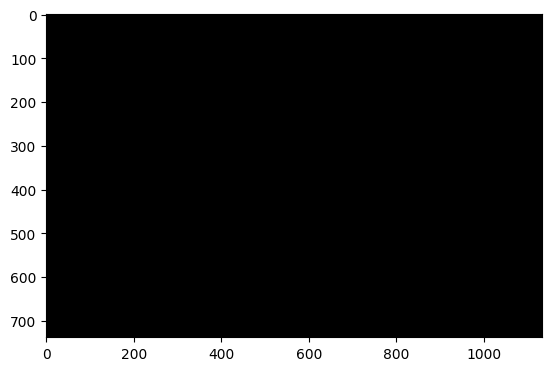

In [11]:
img = plt.imread(path+file_name+'_conv_gpu.jpg')
plt.imshow(img)
plt.show()